# 目的
记录当前ETF的仓位和价格位置。从而观察这套交易是好还是坏？
也可以基于历史的数据，帮助我们判断，当前应该继续加仓还是应该减仓。
所以基本上，我们可以有两套建议系统，第一套是基于位置计算仓位的非线性函数。
另一种是基于历史数据的建议，对比历史上同位置的交易，我们可以这么想，
也就两种情况，第一种是历史的成本高：当时这个位置的成本这么高，最后也挣钱了，现在成本低，可以继续加仓，加加加
第二种是历史的成本更低：当时这个位置，同样的仓位成本已经这么低了，那现在这笔交易是有风险的，等继续跌，跌了再加仓。还有种是历史成本低，同时历史仓位更重，计算加仓成本和历史水平一致的话，就可以继续加仓。如果历史是仓位轻，成本低，这种参考意义就不大了。

首先我们要对一个交易系统进行评分。

什么是交易周期？我定义为从开仓到清仓的这整个流程，这称之为一次长期的交易，这期间一定会包含很多次网格交易，以及底仓建立，高位出货的流程，这一整套的交易，可以称之为一次交易周期。

那么一个交易周期的好坏是什么？

这有分为了运行中的周期和结束的周期。
先讲运行中的周期。这其实就是在讨论一个周期的快照。是一个静态的事物

首先为了公平起见，我们要考虑到两个交易周期它的买入时机，当然买入时机是越低越好。还要考虑到买入的量，总仓位，成本价，现价，框定价格的上下界，现有持仓数，投资金额（已用仓位）= 持仓数*成本价。这些因素都是要考虑到的。

成本价低于现价总是好的，因为这说明当前是盈利的。盈利总是对的，是吧。但是持仓数也是非常重要的，持仓越多，盈利的倍率才会有。低成本的持仓越多越好。我们想要持仓多，同时成本还低于现价格，这是也可遇而不可求的。因为作为左侧交易者，越跌越买，和越涨越卖，说明增长持仓的时候，必然要经历亏损，降低持仓的时候，成本一一定会越来越低。所以对于同一个交易同期，对比它的建仓期和出货期是很难比出优劣的。因此我们应该对比同样在建仓期或者同样在出货期的周期快照，这才有对比的意义。

同时，我希望可以实现自动化记录的功能，每个月只需要我修改一下当前的持仓成本和持仓数，我就可以自动的将全部快照记录到列表中。

# 实现方式
### 我需要登记的数据：

- etf 基金当前框定价格的上下界 （实现完全公式化计算）
   - 目的是计算现价百分位 (val position = (ln(current) - ln(min)) / (ln(max) - ln(min)))
   - 关于etf上下界的计算，也有公式呈现：
      - 上界 一年内最高价
      - 下界 一年内最低价
      - 偏移量 针对新成立的基金
         - 上界增加 0.4*(一年-成立时间)/一年
         - 下界减少  0.2*(一年-成立时间)/一年


- 目前持仓数据
   - etf代码 
   - 交易周期名称（这个可以直接用总仓位 + 建仓时间来代替，不用人工填写）
   - 建仓时间&建仓价格百分位 （一次性填写，不修改）
   - 总仓位 （一次性填写，不修改）
   - 成本价 （需要修改）
   - 现价 （需要，但是从数据库中获取，不需要人工填写）
   - 现持仓数 （需要修改）

### 产品逻辑

- 建立一个excel表格：current_trade.csv
   - 其中有这么几列：etf代码（code），start_time, start_price_position, total_cash, 成本价（cost_price）, 持仓数（position）
- 计算表格，每一个cycle应该有一个表格，用于记录周期快照：xxxx.csv 放在 cycle_history 目录下
   - 每个表格里面是关于这个交易周期的快照信息。
   - 有这么几列，etf代码（code），start_time, start_price_position, total_cash, 前面这几列虽然是固定的，但是还是放进列表中吧，方便后面的计算
   - 后面的新增的原始数据，当前时间（current_time） 成本价（cost_price）, 持仓数（position）, 现价（current_price），最高（max_price），最低（min_price），价格位置（price_position）
   - 然后是通过上面的原始数据计算的数据，持续时间，价格百分比差值（当前价格位置 - 建仓价格位置），收益率，年化收益率






No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


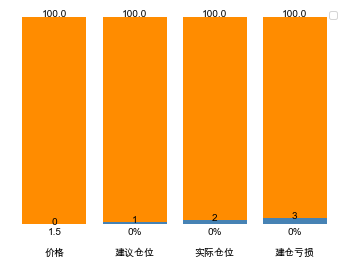

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import mpl

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

size = 4
x = np.arange(size)
a = np.arange(size)
b = np.linspace(100,100,size) # 


plt.bar(x, b, fc='darkorange')
plt.bar(x, a, fc='steelblue')

for xx, yy in zip(x,a):
    plt.text(xx, yy-0.1, str(yy), ha='center')

for xx, yy in zip(x,b):
    plt.text(xx, yy+0.1, str(yy), ha='center')

bottom = [1.5, '0%', '0%', '0%']
for xx, yy in zip(x,b):
    plt.text(xx, -5, str(bottom[xx]), ha='center')

label = ['价格', '建议仓位', '实际仓位', '建仓亏损']
for xx, yy in zip(x,b):
    plt.text(xx, -15, label[xx], ha='center')

plt.legend()
plt.axis('off')

plt.show()








